In [18]:
from helper_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import chromadb
from pathlib import Path
import os
import numpy as np
from tqdm import tqdm
from pypdf import PdfReader

from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

from llama_index.llms import Ollama


# Basic RAG

In [2]:
# Load env var

%reload_ext dotenv
%dotenv

%reload_ext autoreload
%autoreload 2

print(os.environ["DATAPATH"])

/Users/maguettetoure/Desktop/DS_code_maguette/LLM_RAG/llm_rag/data/input


In [3]:
input_dir = Path(os.environ["DATAPATH"])
document_path = input_dir / "microsoft_annual_report_2022.pdf"


In [10]:
# Read pdf
reader = PdfReader(document_path)
pdf_texts = [p.extract_text().strip() for p in reader.pages]
# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]
print(len(pdf_texts)) #NB pages not empty 


#Recursive split
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))
print(f"\nTotal chunks: {len(character_split_texts)}")

90

Total chunks: 347


In [12]:
#Resplit to have a respect a maximum token size for the embedding (256)
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)
print(f"\nTotal chunks: {len(token_split_texts)}")


Total chunks: 349


In [13]:
# SentenceTransformerEmbeddingFunction : extension of Bert embedding model : One vector per sentence
embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]])) #Vector of the chunck

[[0.04256267473101616, 0.0332118384540081, 0.030340105295181274, -0.03486659750342369, 0.0684165358543396, -0.08090916275978088, -0.015474417246878147, -0.001450875774025917, -0.01674446277320385, 0.06770766526460648, -0.050541382282972336, -0.04919533431529999, 0.051399923861026764, 0.09192726761102676, -0.07177833467721939, 0.039519742131233215, -0.012833529151976109, -0.024947531521320343, -0.046228647232055664, -0.024357518181204796, 0.033949632197618484, 0.025502441450953484, 0.02731708437204361, -0.00412622420117259, -0.03633838891983032, 0.003690858604386449, -0.027430452406406403, 0.0047967275604605675, -0.028896227478981018, -0.01887073740363121, 0.036666277796030045, 0.02569585293531418, 0.031312838196754456, -0.06393437087535858, 0.053944025188684464, 0.08225345611572266, -0.04175688326358795, -0.006995797622948885, -0.023485984653234482, -0.030747996643185616, -0.002979220123961568, -0.07790941745042801, 0.009353134781122208, 0.0031628424767404795, -0.022257106378674507, -0

In [16]:
# Create a chroma collection (basilly embedding of our chuncks)
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("my_doc_collection_microsoft", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

349

In [17]:
# Get nearest doc embedding to a query 

query = "What was the total revenue?"
results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]
for document in retrieved_documents:
    print(word_wrap(document))
    print('\n')

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.


74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in milli

In [19]:
# RAG 


def rag(query, retrieved_documents, model):
    information = "\n\n".join(retrieved_documents)

    ##Openai way 
    # messages = [
    #     {
    #         "role": "system",
    #         "content": "You are a helpful expert financial research assistant. Your users are asking questions about information contained in an annual report."
    #         "You will be shown the user's question, and the relevant information from the annual report. Answer the user's question using only this information."
    #     },
    #     {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    # ] 
    # response = openai_client.chat.completions.create(
    #     model=model,
    #     messages=messages,
    # ) 

    #Ollama way (only way? )
    prompt = f""" You are a helpful expert financial research assistant. Your users are asking questions about information contained in an annual report.
    "You will be shown the user's question, and the relevant information from the annual report. Answer the user's question using only this information."
    "Here is the question : {query}. \n Here is the Information you have to use as context: {information}
"""
 
    model_response = model.complete(prompt)
    print(model_response.text, end="\n"*2)
    return model_response



In [20]:
llm_mistral = Ollama(model="mistral", temperature = 0.3)
output = rag(query, retrieved_documents, llm_mistral)

 Based on the information provided in the annual report, the total revenue for the year ended June 30, 2022 was $198.27 billion.



In [22]:
#Get all the embeddings and represent them with umap
import umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/Users/maguettetoure/Desktop/DS_code_maguette/LLM_RAG/llm_rag/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings 

projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

(-4.870594072341919,
 3.1981850147247313,
 1.4880938410758973,
 11.311221373081207)

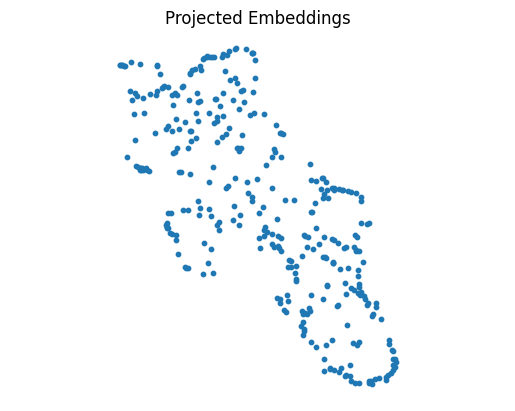

In [24]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


(-4.870594072341919,
 3.1981850147247313,
 1.4880938410758973,
 11.311221373081207)

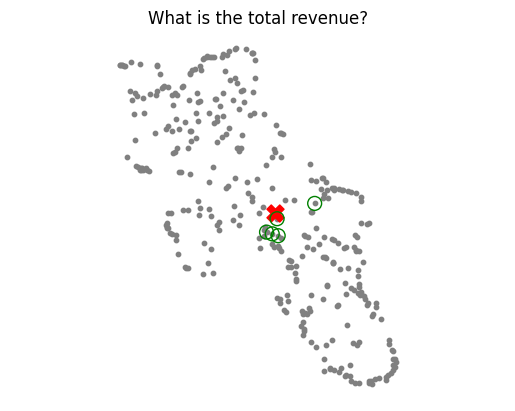

In [25]:
#Plot query in space 
query = "What is the total revenue?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

# Query expansion 

## Expansion with generated answer 

In [26]:
def augment_query_with_generated_answer(query, model):
    prompt = f""" You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
    "Here is the question : {query}.
"""
    model_response = model.complete(prompt)
    print(model_response.text, end="\n"*2)
    return model_response.text



In [28]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_with_generated_answer(original_query, llm_mistral)
joint_query = f"{original_query} {hypothetical_answer}"


 Based on the information available in the annual report, I can confirm that there was indeed turnover in the executive team during the reporting year. Specifically, two executive officers left the company: the Chief Financial Officer (CFO) and the Senior Vice President of Marketing. Both departures were effective as of [specific date]. Their resignations were not the result of any disagreements with the company regarding financial reporting or accounting matters, but rather for personal reasons. The company has initiated a search for their successors and in the interim, other members of the executive team have assumed additional responsibilities. I would recommend checking future reports or investor relations communications for updates on these positions.



In [29]:
#Find closest chunks to joint_query 
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]
output = rag(original_query, retrieved_documents, llm_mistral)




 Based on the information provided in the annual report, there is no explicit mention of significant turnover in Microsoft's executive team as of June 30, 2022. The report does list the current executives, but it does not indicate any changes from the previous reporting period. Therefore, based on this information, I cannot confirm that there was significant turnover in the executive team.



100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


(-4.870594072341919,
 3.1981850147247313,
 1.4880938410758973,
 11.311221373081207)

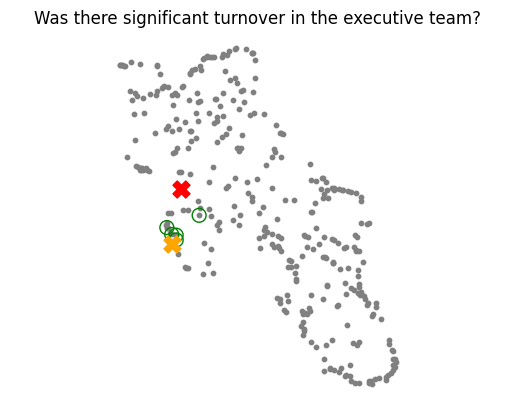

In [30]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with several generated queries  

In [32]:

prompt_generated_queries = """ 
"You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
            Here is the question : 
"""

def get_llm_response(prompt, query, model):
    prompt_and_query = prompt+query 
    model_response = model.complete(prompt_and_query)
    print(model_response.text, end="\n"*2)
    return model_response.text

In [33]:
generated_queries = get_llm_response(prompt_generated_queries, original_query, llm_mistral)

 1. How many new executives were appointed last year?
2. Were there any resignations or terminations among the executive team?
3. Who are the new members of the executive team and what are their previous work experiences?
4. What was the reason for the turnover in the executive team?
5. Is there any information regarding the impact of the executive turnover on the company's performance?



In [37]:
queries = [original_query] + generated_queries.split("\n")
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

output = rag(original_query, unique_documents, llm_mistral)



 Based on the information provided, there is no explicit mention of significant turnover in Microsoft's executive team during the period covered by the annual report. However, we do see that the company has a strong commitment to diversity and inclusion, with an emphasis on employee culture and support for various employee resource groups. Additionally, the board of directors consists of several independent directors and includes an audit committee to ensure financial reporting and internal control oversight.



100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


(-4.870594072341919,
 3.1981850147247313,
 1.4880938410758973,
 11.311221373081207)

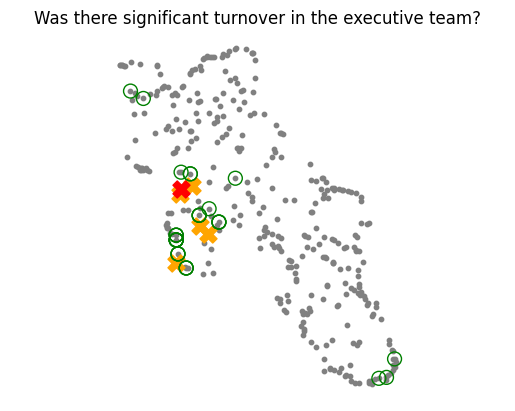

In [38]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(generated_queries.split("\n"))

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

Query expansion allow the retrieval system get more potential relevant information to use as llm context information  

# Cross encoder reranking 
How semantically closed are the retriever documents to the initial query 

In [39]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

pairs = [[query, doc] for doc in unique_documents]
scores = cross_encoder.predict(pairs) #the smaller the better 
print("Scores:")
for score in scores:
    print(score)

config.json: 100%|██████████| 794/794 [00:00<00:00, 1.27MB/s]
pytorch_model.bin: 100%|██████████| 90.9M/90.9M [00:01<00:00, 56.9MB/s]
tokenizer_config.json: 100%|██████████| 316/316 [00:00<00:00, 2.95MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 13.5MB/s]
special_tokens_map.json: 100%|██████████| 112/112 [00:00<00:00, 1.12MB/s]


Scores:
-10.855943
-10.1234665
-11.30724
-11.120598
-11.132856
-11.084261
-11.287134
-10.740638
-11.234249
-11.361895
-11.099549
-11.208566
-11.27523
-8.610773
-11.213577


In [45]:
topn = 5
topn_retrieved_doc = []
print("New Ordering:")
for o in np.argsort(scores)[:-topn-1:-1]:
    print(o+1)
    topn_retrieved_doc.append(list(unique_documents)[o])

New Ordering:
14
2
8
1
6


In [47]:
output = rag(original_query, topn_retrieved_doc, llm_mistral)


 Based on the information provided in the annual report, there is no explicit mention of significant turnover in the executive team during the fiscal years 2021 and 2022. However, the text does indicate that there were changes to the employee stock purchase plan (ESPP) in 2021, with the approval of a successor ESPP with a ten-year expiration date. This change could potentially impact executive compensation and turnover, but it is not directly stated in the provided information that there was significant turnover among executives as a result of this change. Therefore, based on the given information, I cannot definitively answer whether there was significant turnover in the executive team.



100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


(-4.870594072341919,
 3.1981850147247313,
 1.4880938410758973,
 11.311221373081207)

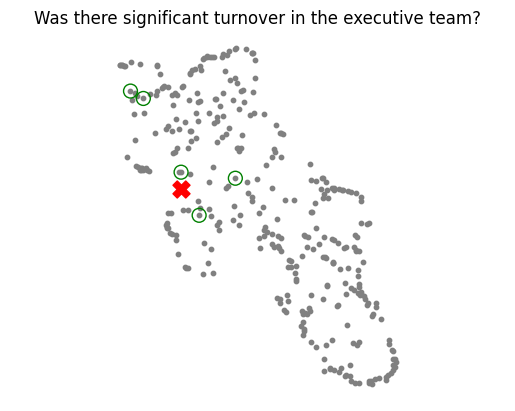

In [52]:
result_embeddings = embedding_function(topn_retrieved_doc)
#result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
#plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

# Embedding Adaptors 

In [53]:
import torch

In [ ]:
#Create a dataset with evaluations : (query , document_retrieved) -> 0 : not related, 1 : related 

In [54]:
prompt_generated_questions = """You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."""
generated_questions = get_llm_response(prompt_generated_questions, "", llm_mistral)

 1. What is the company's revenue trend over the past few years?
2. What are the company's major sources of revenue?
3. What is the company's gross profit margin and how has it changed over time?
4. What is the company's operating income and how does it compare to the previous year?
5. What are the company's operating expenses and any significant changes?
6. What is the company's net income and earnings per share (EPS)?
7. What is the company's debt-to-equity ratio and how has it changed?
8. What is the company's cash flow from operations, investing, and financing activities?
9. What are the company's current assets and liabilities?
10. What is the company's quick ratio and current ratio?
11. What is the company's return on equity (ROE) and return on assets (ROA)?
12. What is the company's dividend policy and payout ratio?
13. What are the company's key performance indicators (KPIs) and how have they changed?
14. Are there any significant one-time items or non-recurring expenses in the

In [60]:
prompt_evaluation = """ You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        Output only 'yes' or 'no'. """

def evaluate_results(query, statement, prompt_eval):
    query_and_doc = f"Here is the query {query}, Statement: {statement}"
    output = get_llm_response(prompt_eval, query_and_doc, llm_mistral)
    
    content = output.split(",")[0]
    if "Yes" in content:
        return 1
    return -1

results = chroma_collection.query(query_texts=generated_questions.split("\n"), n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [63]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []


for q, query in enumerate(tqdm(generated_questions.split("\n"))):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document, prompt_evaluation))


  0%|          | 0/15 [00:00<?, ?it/s]

 Yes, the statement provides information on revenue trends for some of the company's segments over the past fiscal year.

 Yes. The statement provides revenue figures for each of the company's significant product and service offerings for the past three fiscal years, which can help evaluate the revenue trend over time for those specific business segments.

 Yes, the statement provides information relevant to evaluating the company's revenue trend over the past few years. The statement mentions that financial metrics, including revenue, are disclosed in the MD&A or notes to the financial statements and are calculated in accordance with GAAP. Additionally, the statement explains updates made to the presentation and calculation of certain metrics in fiscal year 2022, as well as the acquisition of Nuance in the third quarter of that fiscal year, which could impact revenue trends.

 No, the given statement does not directly provide information about the company's revenue trend over the past

  7%|▋         | 1/15 [00:56<13:14, 56.74s/it]

 Yes, the statement provides information about the seasonality of the company's revenue and when it is higher in a given fiscal year. However, it does not directly provide the numerical data for the revenue trend over the past few years. To obtain that information, you would need to refer to the financial statements and notes, specifically note 19 – segment information and geographic data, as mentioned in the statement.

 Yes, the statement is relevant to understanding the company's major sources of revenue. However, it should be noted that the information provided in the statement only shows revenue from specific business segments (productivity and business processes, intelligent cloud, and more personal computing), but not the total revenue for the company. To get a complete picture of the company's major sources of revenue, it would be necessary to add up the revenues from all segments and compare that to the total revenue reported in the financial statements. Additionally, the stat

 13%|█▎        | 2/15 [01:48<11:41, 53.98s/it]

 Yes, the statement is relevant to understanding the company's major sources of revenue as it provides information on sales and marketing expenses as a percentage of revenue and the percentage change in sales and marketing expenses between 2021 and 2022.

 Yes, the statement is relevant to evaluating the company's gross profit margin and how it has changed over time. The statement provides information about the changes in gross margin percentage for the company as a whole and for specific segments, as well as the factors driving those changes. It also mentions increases in operating expenses related to investments in cloud engineering and other areas, which can impact gross profit margin.

 Yes, the statement provides information on the gross profit margin percentage for each segment and the change in operating income percentage for each segment over the past year. However, it does not directly state the gross profit margin for the company as a whole or how it has changed over time. It

 20%|██        | 3/15 [02:47<11:15, 56.30s/it]

 Yes. The statement provides the necessary data to calculate the gross profit margin for each year and compare it over time.

 Yes. The statement is relevant as it indicates that the MD&A section of Microsoft's 2022 Form 10-K report discusses the company's operating results for the year ended June 30, 2022, and provides a comparison to the previous year. Operating income can be determined by reviewing this discussion, as it typically includes information about changes in revenues, costs of goods sold, operating expenses, and other operating income or expense items.

 Yes, the statement provides the operating income for the given years.

 Yes, the statement is relevant for evaluating the company's operating income as it provides the operating income figures for both years and mentions an unfavorable foreign currency impact on both gross margin and operating income.

 Yes, the statement is relevant to evaluating the company's operating income as it provides information on the segment ope

 27%|██▋       | 4/15 [03:43<10:17, 56.10s/it]

 No, the given statement does not directly provide information about the company's operating income or a comparison to the previous year. However, it does mention that additional information on operating segments and financial performance can be found in Note 19 of the Form 10-K for fiscal year 2022. Therefore, users should refer to Note 19 for the specific operating income data and comparison to the previous year.

 Yes, the statement is relevant to evaluating the company's operating expenses and any significant changes. The statement provides information on the company's general and administrative expenses, which is a component of operating expenses, and indicates that these expenses increased by $793 million or 16%. The statement also breaks down the components of other income (expense), net, which can provide additional context for understanding the company's financial performance.

 Yes, the statement is relevant to evaluating the company's operating expenses and any significant c

 33%|███▎      | 5/15 [04:39<09:20, 56.10s/it]

 No, the given statement does not provide information on the company's operating expenses or any significant changes to them. The statement is an auditor's report on Microsoft Corporation's internal control over financial reporting for the fiscal year ended June 30, 2022.

 The given statement does not directly provide information about the company's net income or earnings per share (EPS). Therefore, 'no', it is not relevant to the query. However, the statement does mention the computation of EPS using the weighted average number of shares outstanding and dilutive potential common shares, which is consistent with the information provided in the financial statements.

 Yes, the statement provides the necessary information to calculate both net income and earnings per share (EPS) for the given company. The statement lists three different net income figures, but it also includes corresponding EPS figures for each net income value, as well as the number of basic and diluted weighted averag

 40%|████      | 6/15 [05:35<08:25, 56.15s/it]

 Yes, the statement provides information relevant to calculating the company's net income and earnings per share (EPS), specifically the basic EPS (a/b) and diluted EPS (a/c).

 Yes, the statement is relevant to evaluating a company's debt-to-equity ratio as it discusses the issuance and exchange of debt, which directly impacts the company's debt levels. However, it does not provide specific numbers for the debt-to-equity ratio or changes over time, so additional research would be needed to fully answer the query.

 Yes, the statement provides the necessary information to calculate the debt-to-equity ratio. However, it does not directly state the ratio or how it has changed over time. To answer the full question, you would need to calculate the debt-to-equity ratio using the given figures for total liabilities and stockholders' equity.

 No. The statement does not provide information about the company's debt-to-equity ratio or how it has changed. It is discussing the factors considered

 47%|████▋     | 7/15 [06:29<07:23, 55.44s/it]

 No, the statement does not provide information about the company's debt-to-equity ratio or how it has changed. The statement is focused on comparing the 5-year cumulative total return of Microsoft Corporation with that of the S&P 500 index and the Nasdaq Computer index.

 The statement provides information on net cash from operations, financing activities, and investing activities. However, it does not directly provide the total cash flow from operations, investing, and financing activities as requested in the query. Therefore, it is relevant but not a complete answer to the question.

To get the total cash flow from operations, investing, and financing activities, you would need to add up the net cash figures for each activity category provided in the statement. For example:

Cash flow from operations = net cash from operations
Cash flow from investing = investing additions + acquisitions + purchases of investments - maturities of investments
Cash flow from financing = net cash used 

 53%|█████▎    | 8/15 [07:23<06:23, 54.83s/it]

 No, the statement does not directly provide the cash flow from operations, investing, and financing activities as requested. The information provided is mainly related to balance sheet items and cash dividends declared per common share.

 Yes, the statement provides information on the company's total liabilities and stockholders' equity, which can be used to calculate current liabilities and current assets (current assets = total assets - total liabilities). However, the statement does not directly provide the current asset and liability figures. The accompanying notes mentioned in the statement should be consulted for this information.

 Yes. The statement provides the current assets and liabilities for the company as requested in the query.

 Yes, the statement provides information on intangible assets, which are considered part of current assets or liabilities depending on their nature and whether they meet the definition of current. However, it does not directly provide the total 

 60%|██████    | 9/15 [08:10<05:15, 52.51s/it]

 Yes, the statement is relevant to answering the question as it provides information on the gross derivative assets and liabilities of the company, which are a type of current asset (derivative assets) and current liability (derivative liabilities), respectively.

 No, the statement does not provide information on the company's quick ratio and current ratio. The statement is about the 5-year cumulative total return of Microsoft Corporation compared to the S&P 500 index and the Nasdaq Computer index.

 Yes, the quick ratio and current ratio are typically discussed in the MD&A section of a company's financial statements. However, it is important to note that the specific numbers for these ratios may not be directly provided in the MD&A text itself, but rather can be found in the accompanying financial statements and notes to financial statements.

 No, the given statement does not provide information about the company's quick ratio and current ratio.

 Yes, the statement is relevant as i

 67%|██████▋   | 10/15 [08:55<04:10, 50.07s/it]

 Based on the given query and statement, the statement is not directly relevant to calculating a company's quick ratio or current ratio. These ratios are calculated using data from the balance sheet and income statement, primarily related to a company's liquidity and solvency. The statement provided discusses various factors that impact financial reporting and accounting estimates, which may indirectly affect a company's financial position but do not provide the necessary data for calculating quick or current ratios.

 Based on the given query and statement, the statement is not directly providing the ROE and ROA figures. However, the statement does mention the total liabilities and stockholders' equity, which are necessary components to calculate these ratios. Therefore, if the user has access to additional financial information such as net income, they could use this data along with the provided liability and equity figures to calculate ROE and ROA.

Answer: Yes (with some additional

 73%|███████▎  | 11/15 [09:45<03:19, 49.98s/it]

 Yes, the statement provides the necessary information to calculate ROA and ROE. The total assets and equity data can be used to calculate ROA, while the total assets and stockholders' equity data can be used to calculate ROE.

 The statement provides information on the dividends per share, but it does not directly mention the company's dividend policy or payout ratio. Therefore, based on the given query, the statement is only partially relevant. To fully answer the query, additional information about the company's dividend policy and payout ratio would be needed.

 Yes, the statement provides information on the company's dividend policy with the cash dividends declared per common share and the payout ratio can be calculated as Cash Dividends / Net Income. However, it is important to note that this information is for specific periods mentioned in the statement and users should refer to the accompanying notes for more context.

 Yes, the statement provides information related to the com

 80%|████████  | 12/15 [10:47<02:40, 53.58s/it]

 Yes. The statement provides the common stock and retained earnings information, which is relevant to determining a company's dividend policy and payout ratio. However, the statement does not directly provide the dividend policy or payout ratio; it only shows the common stock dividends and repurchases, as well as retained earnings. To calculate the payout ratio, you would need to find the net income for each year and divide the total common stock dividends by the net income.

 Yes, the statement is relevant to evaluating key performance indicators (KPIs) and their changes in a company. The statement indicates that the company uses metrics to assess business performance, discloses these metrics to investors for transparency and evaluation, and mentions that commercial and other business metrics are interconnected based on customer usage. This suggests that understanding the company's KPIs and how they have changed can provide valuable insights into the company's financial health and per

 87%|████████▋ | 13/15 [11:49<01:52, 56.15s/it]

 Yes, the statement is relevant to evaluating the company's key performance indicators (KPIs) and how they have changed as it provides information on revenue growth for different product lines, including dynamics products and cloud services, LinkedIn, server products and cloud services, and more personal computing segment. This information can help in understanding the company's business performance and identifying trends.

 Yes. While the statement does not explicitly mention one-time items or non-recurring expenses, it does discuss estimates and assumptions which can impact financial statements in a significant way and could potentially represent such items. It's important to review the notes in detail to identify any specific estimates or assumptions that may be non-recurring or material to understanding the financial performance of the company.

 Yes. The statement mentions that there are critical accounting estimates, which are estimates with a significant level of estimation unce

 93%|█████████▎| 14/15 [12:42<00:55, 55.31s/it]

 Yes, the given statement is relevant to the query as it discusses the importance of accurately recording transactions and dispositions of a company's assets in accordance with generally accepted accounting principles. One-time items or non-recurring expenses may impact the financial statements and require special consideration when applying these principles.

 Yes, the capital expenditure plan for the upcoming year may be discussed in the management's discussion and analysis (MD&A) section of Microsoft Corporation's Form 10-K for fiscal year 2023. However, it is not guaranteed as the information regarding capital expenditures might not always be explicitly stated in this section. It would be best to carefully read through the entire MD&A and related sections to gather as much relevant information as possible. Additionally, checking other financial reports or investor relations resources from Microsoft could provide further insight into their capital expenditure plans.

 No, the statem

100%|██████████| 15/15 [13:30<00:00, 54.06s/it]

 No, the statement does not provide information about the company's capital expenditure plan for the upcoming year. The statement primarily discusses the company's balance sheet items, including write-offs and allowance for doubtful accounts, as well as their net receivables and financing receivables.



In [65]:
len(adapter_labels)
#adapter_labels

150

In [66]:
#torch data 

adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

In [67]:
#Model update embedding so query and related docs are closer and query and non related docs further 
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

#Random Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)


In [68]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
        

  0%|          | 0/100 [00:00<?, ?it/s]/Users/maguettetoure/Desktop/DS_code_maguette/LLM_RAG/llm_rag/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


In [69]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.6589867472648621


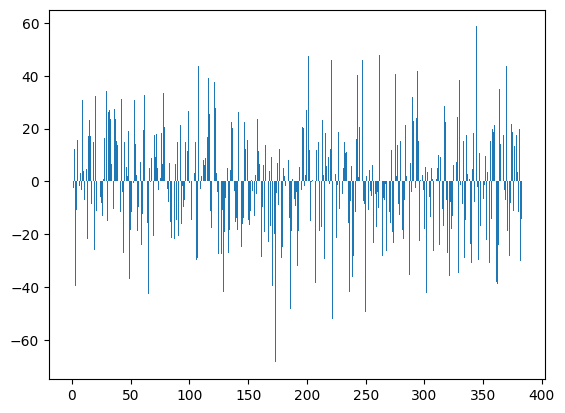

In [70]:
#Visualize change from a test vector with 1 to a new adapted vector
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

100%|██████████| 389/389 [03:01<00:00,  2.15it/s]


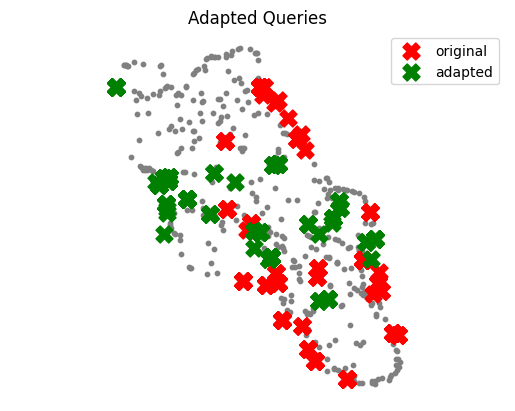

In [71]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T
projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()